# Measuring Access to Healthcare in the IE

### Software

To do a full-statck assessment of accessibility we need to link together a few diferent pieces of software:

- [`urbanaccess`]() builds a routable, multimodal transportation network. It consumes data from (1) OpenStreetMap and (2) GTFS and combines them into a network whose distance between nodes is measured in travel time
- [`pandana`]() finds the shortest path through the network between all pairs of nodes using fast underlying C++ library, and can optionally create distance-weighted sums of resources--a simple measurre of accessibility that accounts for space but not competition. `pandana` consumes (1) the network generated by `urbanaccess` and (2) a set of oigins and (3) destinations. We will use `pandana` to create the shortest-path travel cost matrix relating origins to destinations
- [`access`]() creates measures of accessibility that account for distance traveled and include various weighting schemes to discount for competition. `accesss` consumes geodataframes representing (1) supply and (2) demand, and (3) a travel cost matrix. In our case, (1) is equivalent to the desitnation set above, (2) is a set of population counts, and (3) is the output from `pandana`

### Data

- OSM
    - urbanaccess (and osmnet) have the ability to download data from OSM in the format they need using a function called `network_from_bbox` which is nice, but can be very time consuming depending on the size of the network
    - I have stored pre-built metropolitan scale networks (extending 8km beyond the metro border, so supporting queries up to that range) in [our quilt bucket](https://open.quiltdata.com/b/spatial-ucr/packages/osm/metro_networks_8k)
- GTFS
    - [transitfeeds](https://transitfeeds.com/p/riverside-transit-agency/531) is a good place to get up-to-date gtfs data, but it can be hard to ensure you've included every relevant transit agency serving the study area (and impossible to know whether there's another agency that hasnt yet posted its data there)

In [49]:
import quilt3
import pandas as pd
import numpy as np
import geopandas as gpd
import urbanaccess as ua
from access import access
import pandana as pdna

If you get "ImportError: cannot import name 'vincenty' from 'geopy.distance'" you need to downgrade geopy to version 1.9, e.g.

```
pip install geopy==1.9
```

(I sent [a fix](https://github.com/UDST/osmnet/pull/21) that thas been merged, but still waiting on a new release of the `osmnet` package)

#### Creating a multimodal network

download OSM data from our quilt bucket

In [4]:
p = quilt3.Package.browse("osm/metro_networks_8k", "s3://spatial-ucr")

Loading manifest: 100%|██████████| 390/390 [00:00<00:00, 34345.61entries/s]


In [5]:
p['40140.h5'].fetch(dest="../data/")

100%|██████████| 42.1M/42.1M [01:51<00:00, 376kB/s] 


PackageEntry('file:///home/knaaptime/projects/healthacc/data/')

In [2]:
# read in the pre-saved OSM network using pandana

osm_network = pdna.Network.from_hdf5("../data/40140.h5")

In [28]:
osm_network.edges_df

from          to    distance    weight net_type
655386     3870037827      655386  3870037827  155.135617  1.927941     walk
658887     1084237677      658887  1084237677   35.835411  0.445343     walk
           6129921495      658887  6129921495  135.429465  1.683044     walk
658891     658887          658891      658887   22.671470  0.281749     walk
           3872361358      658891  3872361358   58.284071  0.724323     walk
...                           ...         ...         ...       ...      ...
6568884589 6568884598  6568884589  6568884598   16.191294  0.201217     walk
6568884598 54822293    6568884598    54822293  652.160829  8.104699     walk
6569138136 4818982770  6569138136  4818982770   85.247847  1.059414     walk
6569138137 6569167594  6569138137  6569167594   22.567415  0.280456     walk
6569167594 4028993338  6569167594  4028993338   35.454802  0.440613     walk

[742113 rows x 5 columns]

Now we read in GTFS data using urbanaccess. From here, we're essentially following the tutorial from https://github.com/UDST/urbanaccess/blob/dev/demo/simple_example.ipynb

Two things to note:
- First, `ua` uses a deprecated pandas convention (`to_matrix` instead of `values`) so you need to either fix that code in `network.py` or install the version from my fork. 
- Second `ua` makes some  nontraditional design desisions. Rather than expose something like a Network class, they keep track of a global network object in  `ua.network.ua_network`. Thus, most of the functions dont return  an object, but modify the global network 

In [3]:
bbox=(-117.802539  ,   33.425932  , -114.131211  ,   35.80962942)
validation = True
verbose = True
# small bbox for testing purposes
remove_stops_outsidebbox = True
append_definitions = True

We can use the built-in downloader to grab GTFS data for riverside county

In [47]:
ua.gtfsfeeds.search(search_text='riverside', add_feed=True)

ua.gtfsfeeds.download(data_folder="../data")

Note: Your use of a GTFS feed is governed by each GTFS feed author license terms. It is suggested you read the respective license terms for the appropriate use of a GTFS feed.
Found 2 records that matched ['riverside'] inside ['name', 'url', 'dataexchange_id', 'feed_baseurl'] columns:
Added 2 feeds to gtfs_feeds: {'Riverside Transit Agency': 'http://www.gtfs-data-exchange.com/agency/riverside-transit-agency/latest.zip', 'Palo Verde Valley Transit Agency': 'http://www.gtfs-data-exchange.com/agency/palo-verde-valley-transit-agency/latest.zip'}
Added 2 records to gtfs_feed list:
../data/gtfsfeed_zips does not exist. Directory was created
2 GTFS feeds will be downloaded here: ../data/gtfsfeed_zips
Riverside Transit Agency GTFS feed downloaded successfully. Took 1.97 seconds for 1,235,360.0KB
Palo Verde Valley Transit Agency GTFS feed downloaded successfully. Took 1.47 seconds for 57,061.0KB
GTFS feed download completed. Took 3.44 seconds
../data/gtfsfeed_text does not exist. Directory was 

In [4]:
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df("../data/gtfsfeed_text/",
                                                    validation,
                                                    verbose,
                                                    bbox,
                                                    remove_stops_outsidebbox,
                                                    append_definitions)

GTFS text file header whitespace check completed. Took 0.06 seconds
--------------------------------
Processing GTFS feed: Palo Verde Valley Transit Agency
The unique agency id: palo_verde_valley_transit_agency was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.00 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
No GTFS feed stops were found to be outside the bounding box coordinates
Palo Verde Valley Transit Agency GTFS feed stops: coordinates are in northwest hemisphere. Latitude = North (90); Longitude = West (-90).
Appended route type to stops
Appended route type to stop_times
--------------------------------
--------------------------------
Processing GTFS feed: Riverside Transit Agency
The unique agency id: riverside_transit_agency was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.01 seconds
Unique GTFS feed id operation complete. Took 0.00 sec

In [5]:
# transform the raw gtfs data into a transit network

ua.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
9 service_ids were extracted from calendar
1,479 trip(s) 49.63 percent of 2,980 total trip records were found in calendar for GTFS feed(s): ['palo verde valley transit agency', 'riverside transit agency']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
1,479 of 2,980 total trips were extracted representing calendar day: monday. Took 0.01 seconds
Note: Processing may take a long time depending on the number of records. Total unique trips to assess: 1,479
Starting departure stop time interpolation...
Departure time records missing from trips following m

Here, we create a pointed to the global network so that it's easier to inspect

In [6]:
urbanaccess_net = ua.ua_network

Now we create `ua` version of the OSM version we read in earlier using pandana.  Pandana and urbanaccess share a lot of underlying code but their objects arent interchangeable. So there's probably a way to just read in the OSM data using `ua` instead of `pandana`, but this is the path of least resistance

In [9]:
ua_osm = ua.create_osm_net(osm_edges=osm_network.edges_df,
                              osm_nodes=osm_network.nodes_df.reset_index(),
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


Now all we have to do is integrate the networks and save the result as an h5 file

In [10]:
ua.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False
                             )

Loaded UrbanAccess network components comprised of:
     Transit: 2,686 nodes and 13,215 edges;
     OSM: 486,514 nodes and 742,113 edges
Connector edges between the OSM and transit network nodes successfully completed. Took 1.12 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 2.17 seconds
Network edge and node network integration completed successfully resulting in a total of 489,200 nodes and 760,700 edges:
     Transit: 2,686 nodes 13,215 edges;
     OSM: 486,514 nodes 742,113 edges; and
     OSM/Transit connector: 5,372 edges.


In [29]:
# I think somewhere ua has hardcoded the paths to be `logs` inside the cwd, so you need to move up *two* levels
ua.save_network(urbanaccess_network=urbanaccess_net,
                        filename='../../data/combined_net.h5',
                        overwrite_key = True)

Using existing data/../../data/combined_net.h5 hdf5 store.
Existing edges overwritten in data/../../data/combined_net.h5 hdf5 store.
Using existing data/../../data/combined_net.h5 hdf5 store.
Existing nodes overwritten in data/../../data/combined_net.h5 hdf5 store.


In [20]:
combined_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                            urbanaccess_net.net_nodes["y"],
                              urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]])

Figure created. Took 65.33 seconds


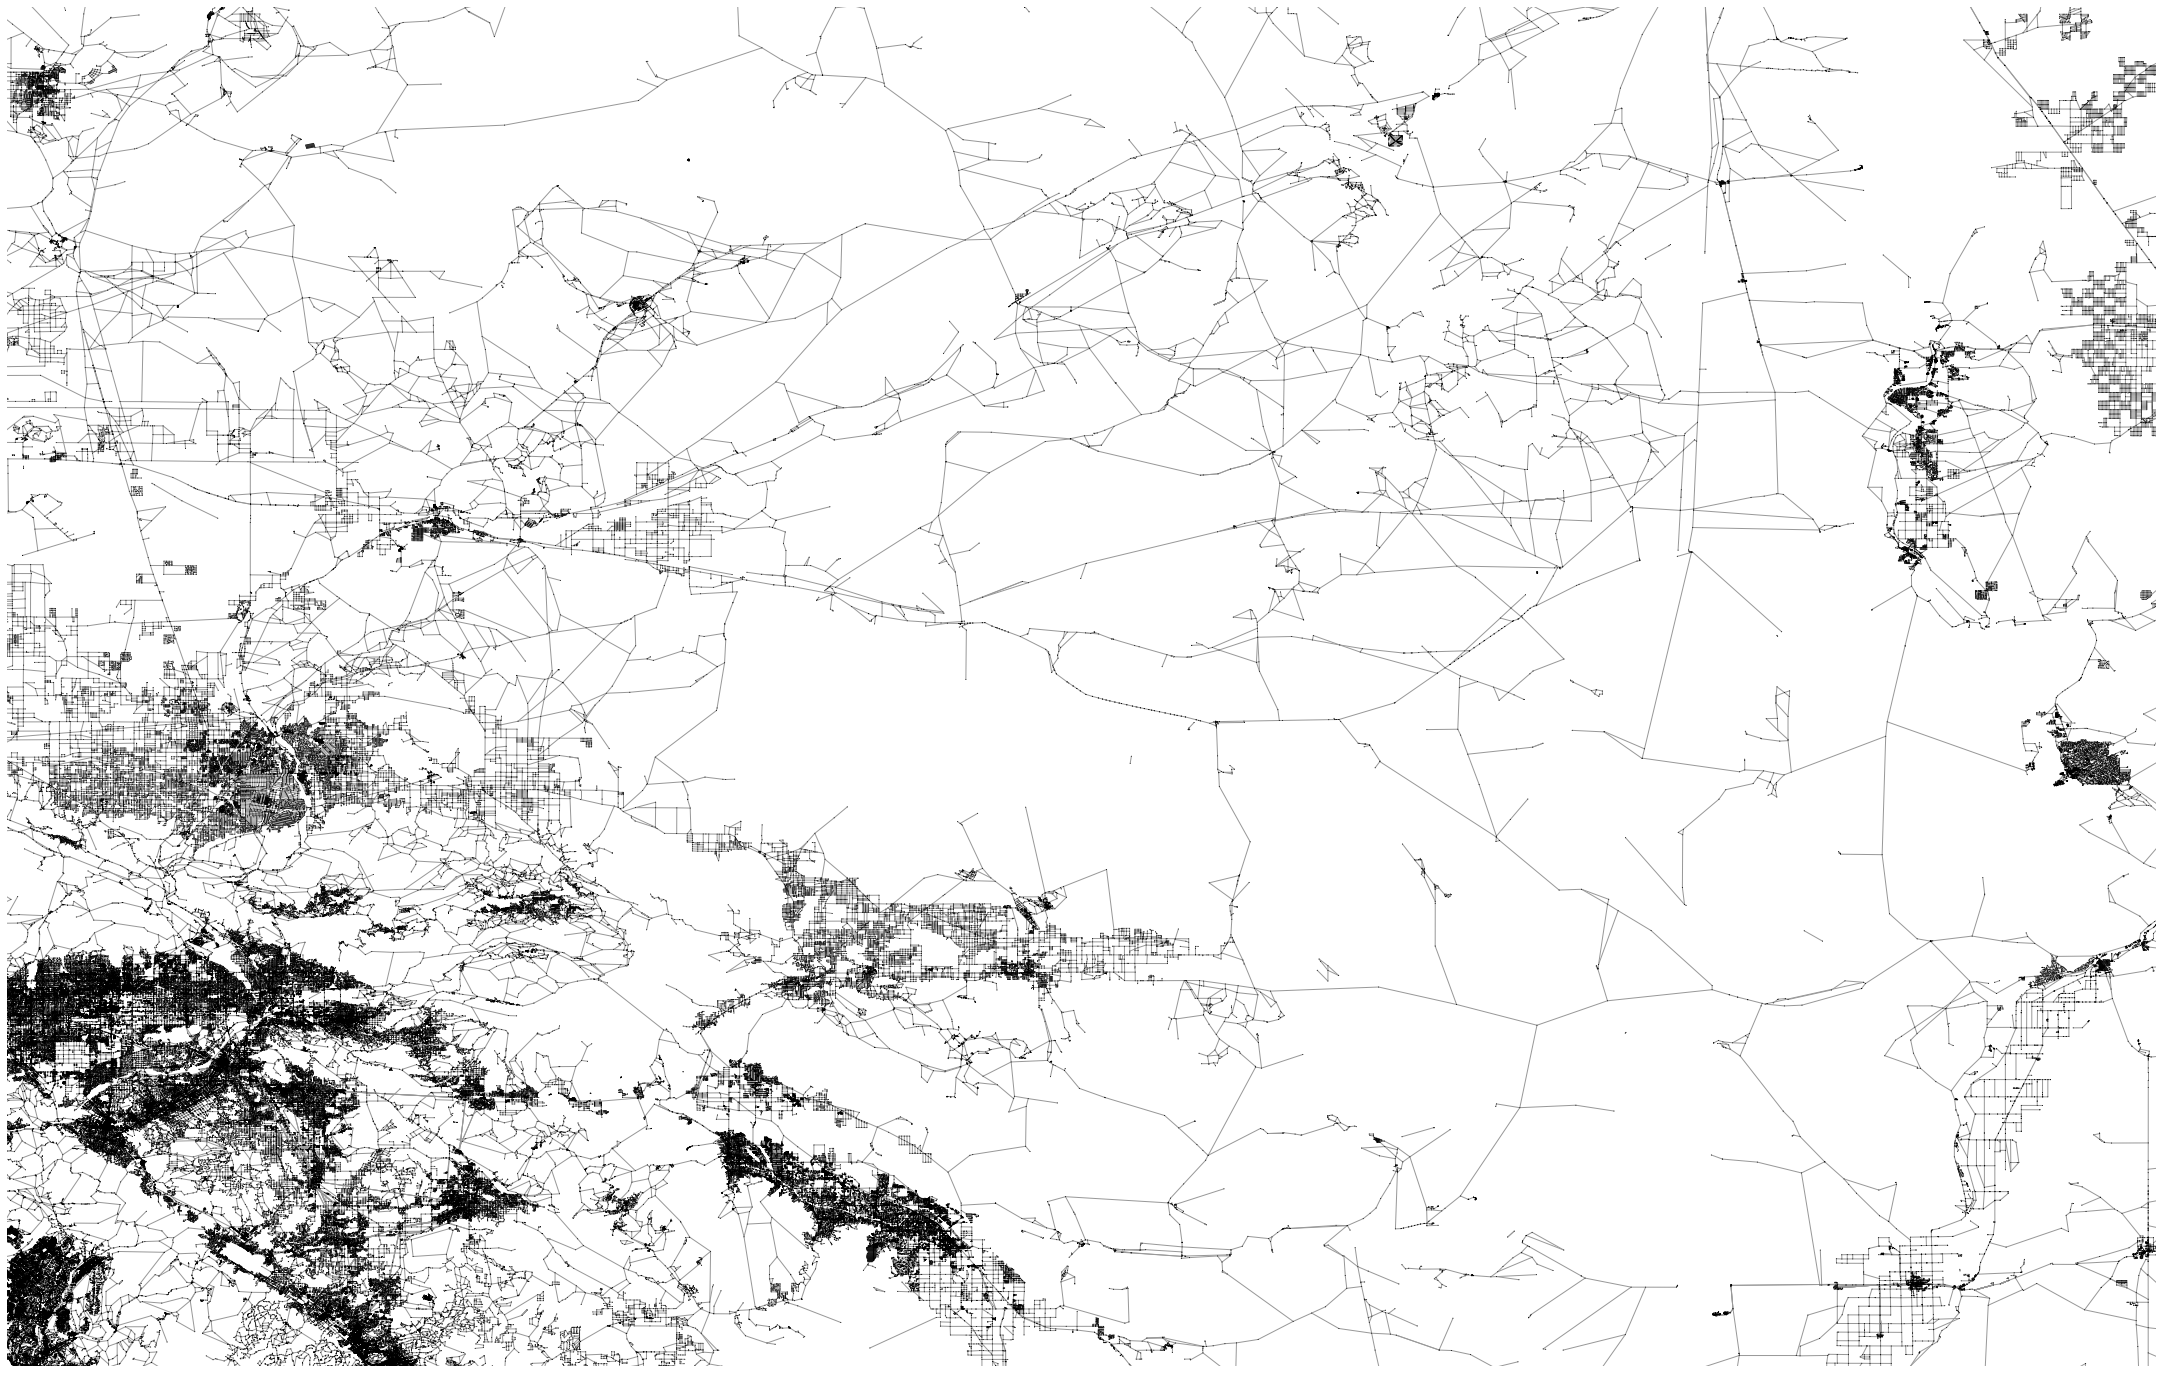

(<Figure size 2772.33x1800 with 1 Axes>, <AxesSubplot:>)

In [26]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                          edges=urbanaccess_net.net_edges,
                          bbox=(-117.802539  ,   33.425932  , -114.131211  ,   35.80962942),
                          fig_height=25,
                          margin=0.02,
                          edge_linewidth=1,
                          edge_alpha=1,
                          node_color='black',
                          node_size=1,
                          node_alpha=1,
                          node_edgecolor='none',
                          node_zorder=3,
                          nodes_only=False)

In [31]:
from geosnap import Community

Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 8429.07entries/s]


In [32]:
socal = Community.from_census(msa_fips='40140', years=[2010])

In [33]:
socal = socal.gdf

And we can use `osmnx` to quickly get poi data related to healthcare locations from openstreetmap

In [35]:
from osmnx import pois

In [36]:
health = pois.pois_from_polygon(socal.unary_union, tags={'amenity':['doctor', 'hospital'],
                                                         'healthcare': True})

<AxesSubplot:>

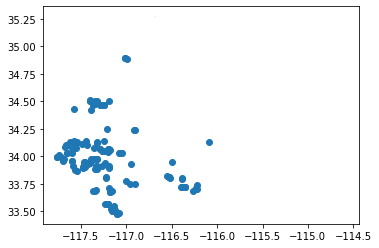

In [37]:
health.plot()

In [38]:
health['care'] = 1

This function uses the shortest path functionality in pandana to calculate
the quickest walking path between every paid of tracts in the IE region

In [39]:
def compute_travel_cost_matrix(origins, destinations, network, reindex_name=False):
    origins = origins.copy()
    destinations = destinations.copy()
    
    origins['osm_ids'] = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
    destinations['osm_ids'] = network.get_node_ids(destinations.centroid.x, destinations.centroid.y).astype(int)
    
    ods = {}

    for origin in origins['osm_ids']:
        ods[f"{origin}"] = network.shortest_path_lengths([int(origin)] * len(origins), destinations['osm_ids'])
    
    if reindex_name:
        df = pd.DataFrame(ods, index=origins[reindex_name])
        df.columns = df.index
    else:
        df = pd.DataFrame(ods, index=origins)
    
    return df

In [40]:
def compute_travel_cost_adjlist(origins, destinations, network, reindex_orig=None, reindex_dest=None):
    origins = origins.copy()
    destinations = destinations.copy()
    
    origins['osm_ids'] = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
    destinations['osm_ids'] = network.get_node_ids(destinations.centroid.x, destinations.centroid.y).astype(int)
    
    ods = []

    for origin in origins['osm_ids']:
        df = pd.DataFrame()
        df['cost'] = network.shortest_path_lengths([int(origin)] * len(origins), destinations['osm_ids'])
        if reindex_dest:
            df['destination'] = destinations[reindex_dest].values
            df['origin'] = origins[origins.osm_ids==origin]['geoid'].values[0]
        else:
            df['destination'] = destinations['osm_ids']
            df['origin'] = origin
        ods.append(df)
    
    combined = pd.concat(ods)
    
    return combined

In [41]:
tract_cost = compute_travel_cost_matrix(socal, socal, combined_net, reindex_name='geoid')

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [42]:
tract_cost

geoid,06071009112,06071009713,06071009800,06071009912,06071010016,06071010420,06071011102,06071011600,06071012300,06065042005,...,06065031401,06065040806,06065042009,06065040603,06065040701,06065042738,06065043309,06071006700,06071008500,06065044804
geoid,,,,,,,,,,,,,,,,,,,,,
06071009112,0.000,302.859,151.045,132.090,191.626,1540.574,672.378,848.217,746.290,854.760,...,821.920,891.014,852.157,829.299,856.380,869.335,884.075,751.192,967.821,1485.106
06071009713,302.859,0.000,157.411,195.046,304.785,1267.512,544.420,898.079,761.751,918.726,...,891.983,976.019,916.123,916.991,943.028,930.642,945.382,814.788,983.282,1496.477
06071009800,151.045,157.411,0.000,49.118,164.134,1401.601,578.794,789.073,721.627,873.064,...,844.063,928.099,870.461,869.432,895.469,884.962,899.702,731.948,943.158,1500.733
06071009912,132.090,195.046,49.118,0.000,123.372,1414.806,552.946,834.687,672.754,824.191,...,795.190,879.226,821.588,820.559,846.596,836.089,850.829,683.075,894.285,1451.860
06071010016,191.626,304.785,164.134,123.372,0.000,1412.153,500.943,940.407,585.294,736.731,...,707.730,791.766,734.128,733.099,759.136,748.629,763.369,595.615,806.825,1364.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06065042738,869.335,930.642,884.962,836.089,748.629,1160.384,670.805,1668.756,244.042,79.935,...,73.407,156.768,60.292,98.415,124.452,0.000,34.885,178.651,237.255,635.916
06065043309,884.075,945.382,899.702,850.829,763.369,1137.209,685.545,1683.496,258.782,94.675,...,88.147,171.508,75.032,113.155,139.192,34.885,0.000,193.391,235.358,612.741
06071006700,751.192,814.788,731.948,683.075,595.615,1318.890,575.747,1515.742,195.601,166.753,...,137.752,221.788,164.150,163.121,189.158,178.651,193.391,0.000,275.809,794.422


In [43]:
tract_adjlist = compute_travel_cost_adjlist(socal, socal, combined_net, reindex_dest='geoid', reindex_orig='geoid')

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [44]:
tract_adjlist

,cost,destination,origin
0,0.000,06071009112,06071009112
1,302.859,06071009713,06071009112
2,151.045,06071009800,06071009112
3,132.090,06071009912,06071009112
4,191.626,06071010016,06071009112
...,...,...,...
817,635.916,06065042738,06065044804
818,612.741,06065043309,06065044804
819,794.422,06071006700,06065044804
820,836.087,06071008500,06065044804


In [45]:
joined  = gpd.sjoin(socal, health[['geometry', 'care']], op='intersects', how='left').groupby('geoid').sum()['care']

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [46]:
socal = socal.dropna(subset=['n_total_pop'])

In [47]:
socal = socal.merge(joined, left_on='geoid', right_index=True)

In [50]:
ac = access(demand_df = socal,
                              demand_index = 'geoid',
                              demand_value = 'n_total_pop',
                              supply_df    = socal,
                              supply_index = 'geoid',
            cost_df=tract_adjlist,
            cost_origin='origin',
            cost_dest='destination',
            cost_name='cost',
            supply_value='care',
            neighbor_cost_df     = tract_adjlist,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'destination',
           neighbor_cost_name   = 'cost'
      )

In [52]:
from access import weights as acweights

In [53]:
gravity = acweights.gravity(scale = 120, alpha = -1)
gaussian = acweights.gaussian(120)

In [61]:
ac.raam(name = "raam", tau = 120);
ac.two_stage_fca(name = "2sfca", max_cost = 120,)
ac.enhanced_two_stage_fca(name = "g2sfca", weight_fn = gravity)
ac.three_stage_fca(name = "3sfca")
ac.weighted_catchment(name = "gravity", weight_fn = gravity)
ac.weighted_catchment(name = "gaussian", weight_fn = gaussian)
ac.fca_ratio(name = "fca60",      max_cost = 60)
ac.fca_ratio(name = "fca120",      max_cost = 120) 

access INFO     :: Overwriting raam_care.
access INFO     :: Overwriting 2sfca_care.
access INFO     :: Overwriting g2sfca_care.
access INFO     :: Overwriting 3sfca_care.
access INFO     :: Overwriting gravity_care.
access INFO     :: Overwriting gaussian_care.


,fca120_care
geoid,
06065030101,0.000083
06065030103,0.000090
06065030104,0.000079
06065030200,0.000081
06065030300,0.000090
...,...
06071025000,0.000104
06071025100,0.000000
06071940100,0.000000


In [55]:
ac.access_df

,n_total_pop,raam_care,2sfca_care,g2sfca_care,3sfca_care,gravity_care,gaussian_care,fca5k_care,fca10k_care
geoid,,,,,,,,,
06065030101,1186.0,1.293555,0.028469,0.076458,0.000042,383.757513,1.587315e+02,0.000069,0.000079
06065030103,2345.0,1.334227,0.032757,0.089438,0.000057,446.936650,1.641098e+02,0.000070,0.000079
06065030104,7828.0,1.325173,0.026833,0.076738,0.000040,384.161883,1.588025e+02,0.000063,0.000079
06065030200,4486.0,1.354344,0.027436,0.083954,0.000044,419.714363,1.611292e+02,0.000073,0.000079
06065030300,4095.0,1.251509,0.034435,inf,0.000054,inf,1.682965e+02,0.000067,0.000079
...,...,...,...,...,...,...,...,...,...
06071025000,9584.0,1.037871,0.000104,inf,0.000100,inf,1.000000e+00,0.000104,0.000079
06071025100,1196.0,6.561619,0.000000,0.002176,0.000000,10.182350,7.213588e-09,0.000000,0.000079
06071940100,1329.0,9.327819,0.000000,0.002458,0.000000,11.470437,8.737643e-13,0.000000,0.000079


In [64]:
results = socal[['geoid', 'geometry']].merge(ac.access_df, left_on='geoid', right_index=True)

In [65]:
results = results.replace([np.inf, -np.inf] ,np.nan)

In [66]:
import matplotlib.pyplot as plt

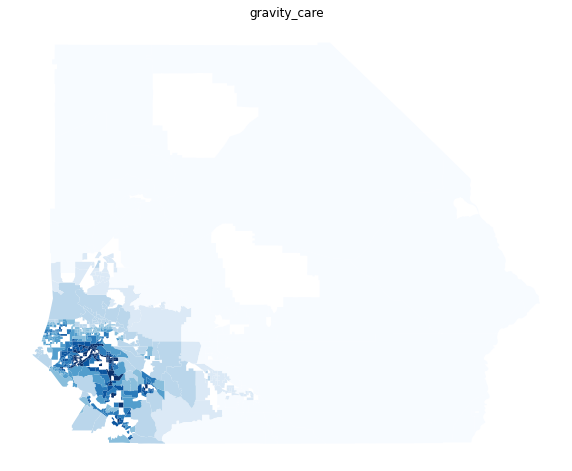

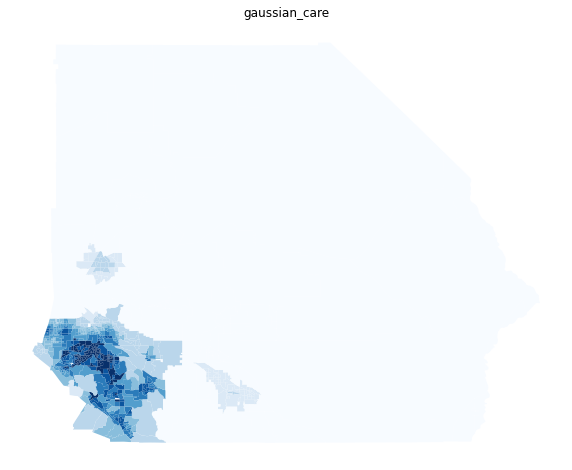

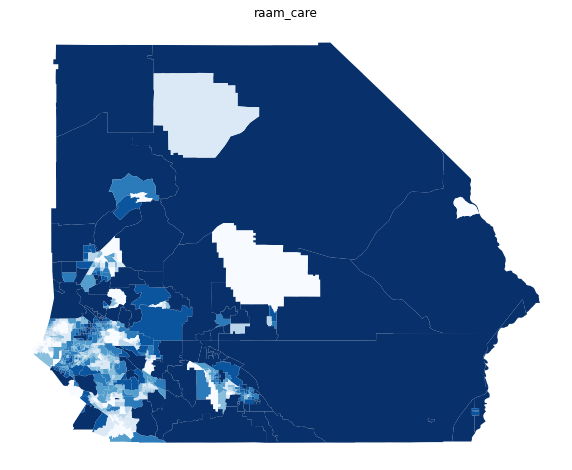

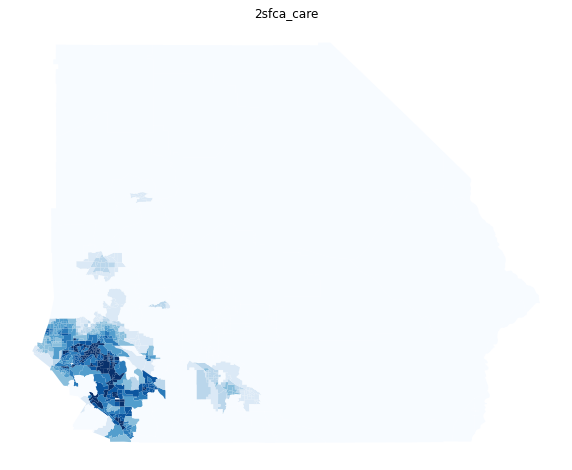

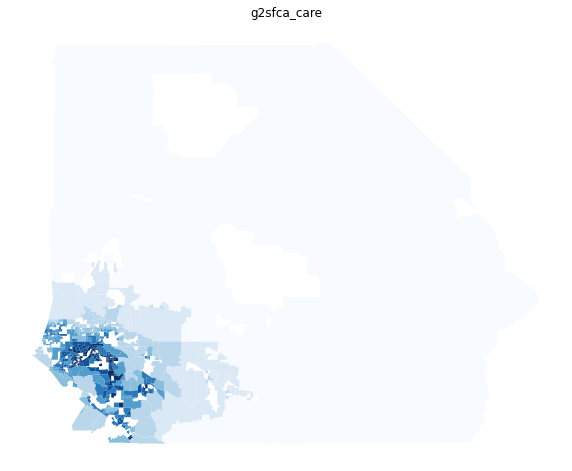

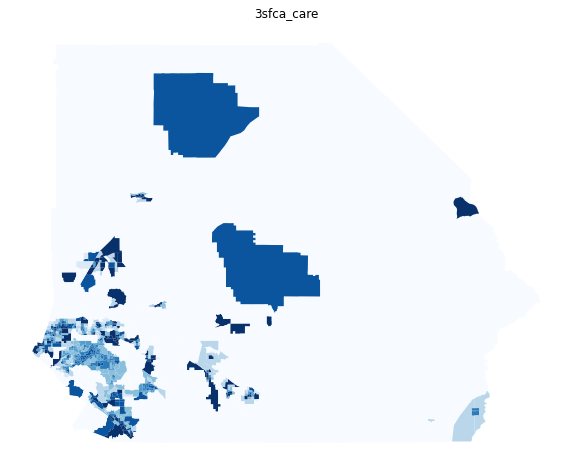

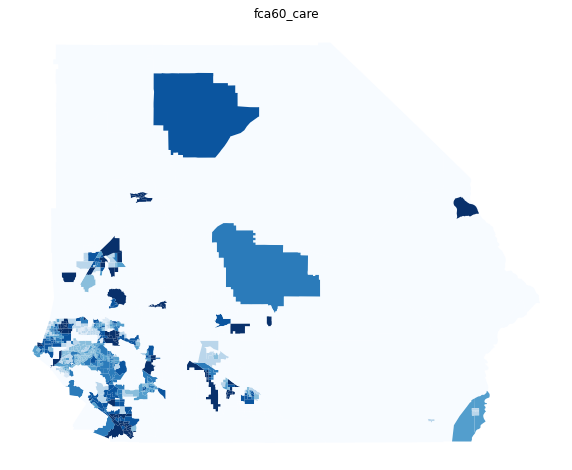

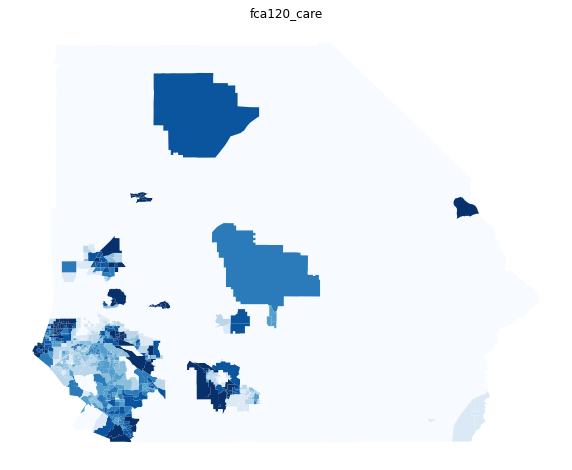

In [67]:
for i in ['gravity_care', 'gaussian_care',
          'raam_care', '2sfca_care', 
         'g2sfca_care', '3sfca_care', 
         'fca60_care', 'fca120_care']:
    fig, ax=plt.subplots( figsize=(10,10))
    results.dropna(subset=[i]).plot(column=i, scheme='quantiles', cmap='Blues', k=8, ax=ax)
    ax.set_title(i)
    ax.axis('off')
    #health.plot(ax=ax, color='red')